In [2]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("cuda")

cuda


# Loading the SAM 2 camera predictor


In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

#### Select an video stream (video or camera)


In [9]:
# import cv2

# cap = cv2.VideoCapture(0)

# if not cap.isOpened():
#     print("Cannot open webcam")
# else:
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             print("Failed to grab frame")
#             break

#         cv2.imshow("Live Webcam", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

predictor.reset_state()

#### Step 1: Add a first click on the first frame


In [5]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))  

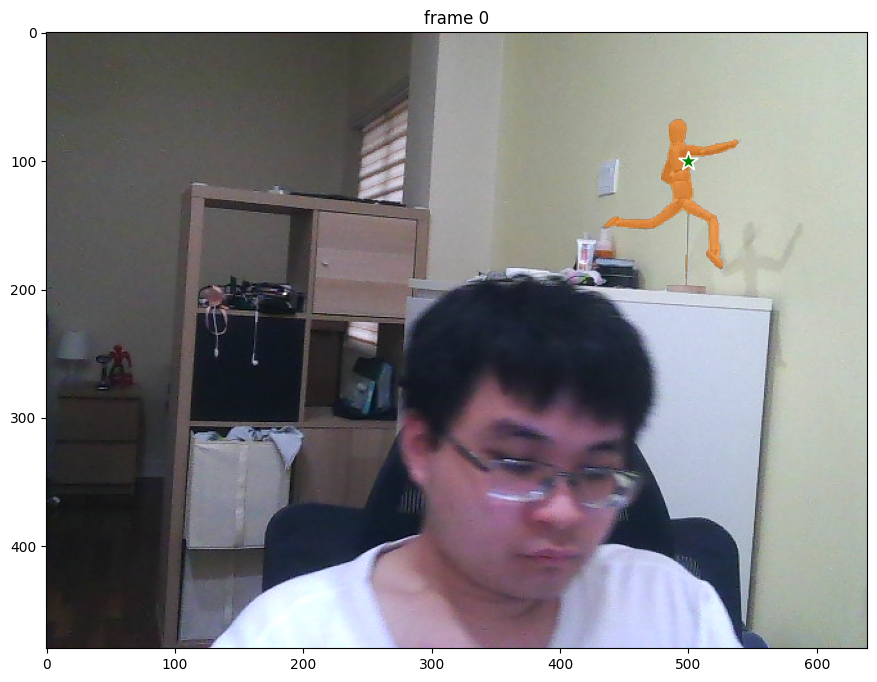

In [ ]:
predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)
start_frame = 100
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot access webcam")
    exit()

# Warm-up: read and discard first N frames
for _ in range(start_frame):
    cap.read()

# Read the 5th frame
ret, frame = cap.read()
if not ret or frame is None:
    print("Failed to capture 5th frame")
    cap.release()
    exit()

height, width = frame.shape[:2]
predictor.load_first_frame(frame)

using_point = True # if True, we use point prompt
using_box = False # if True, we use point prompt
using_mask= False  # if True, we use mask prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
points = np.array([[[500, 100]]])
# for labels, `1` means positive click and `0` means negative click
labels = np.array([[1]])
bbox = np.array([[470, 60, 550, 220]])

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)


if using_point:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    show_points(points[0], labels[0], plt.gca())

elif using_box:
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
    )
    show_box(bbox[0], plt.gca())

elif using_mask:
    mask_img_path="masks/aquarium/aquarium_mask.png"
    mask = cv2.imread(mask_img_path, cv2.IMREAD_GRAYSCALE)
    mask = mask / 255

    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, mask=mask
    )

show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [10]:
from flask import Flask, Response, render_template_string
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image

def overlay_mask_on_frame(frame_rgb, mask, obj_id=None, alpha=0.6):
    """
    Args:
        frame_rgb: (H, W, 3) RGB image as numpy array (uint8)
        mask: (H, W) binary mask (bool or 0/1 int/float)
        obj_id: used for consistent coloring
        alpha: transparency for mask overlay

    Returns:
        Image with overlayed mask
    """
    overlay = frame_rgb.copy()
    color_map = plt.get_cmap("tab10")
    cmap_idx = 0 if obj_id is None else obj_id % 10  # stay within colormap bounds
    rgb_color = np.array(color_map(cmap_idx)[:3]) * 255  # scale to 0–255

    mask = mask.astype(bool)
    overlay[mask] = ((1 - alpha) * overlay[mask] + alpha * rgb_color).astype(np.uint8)
    return overlay


app = Flask(__name__)

vis_gap = 1
ann_frame_idx = 0

def gen_frames():
    global ann_frame_idx
    while True:
        ret, frame = cap.read()
        if not ret:
            print("No frame read from video source")
            break
        ann_frame_idx += 1

        out_obj_ids, out_mask_logits = predictor.track(frame)

        if ann_frame_idx % vis_gap == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mask = (out_mask_logits[0] > 0.0).cpu().numpy()
            mask = np.squeeze(mask)  # Ensure shape is (H, W)
            blended = overlay_mask_on_frame(rgb, mask, obj_id=out_obj_ids[0])

            img = Image.fromarray(blended)
            buf = BytesIO()
            img.save(buf, format='JPEG')
            frame_bytes = buf.getvalue()

            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame_bytes + b'\r\n')

    cap.release()


@app.route('/')
def index():
    return render_template_string('''
        <html>
        <head>
            <title>Segmented Video Stream</title>
        </head>
        <body>
            <h1>Segmented Video Stream</h1>
            <img src="{{ url_for('video_feed') }}">
        </body>
        </html>
    ''')

@app.route('/video_feed')
def video_feed():
    return Response(gen_frames(),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8000, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://192.168.1.5:8000
INFO:werkzeug:Press CTRL+C to quit
